In [8]:
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import re
import numpy as np
import os
import time
import json

from PIL import Image
import pickle
import glob
import pandas as pd


from tensorflow.keras.layers import Lambda, Dense, Input, Embedding, Dropout, Activation,  Conv1D
from tensorflow.keras.layers import GRU,LSTM, Bidirectional, GlobalAveragePooling2D, GlobalMaxPool1D, GlobalAveragePooling2D, GlobalMaxPooling1D, GlobalAveragePooling1D
from tensorflow.keras.layers import Input, Embedding, Dense, Conv2D, MaxPool2D, concatenate
from tensorflow.keras.layers import Reshape, Flatten, Concatenate, Dropout, SpatialDropout1D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
#from keras.layers import TimeDistributed
from tensorflow.keras.models import Sequential, Model, load_model

# text processing
import nltk
from nltk import tokenize

############## parameters
#sampling
n_samples = 790
load_samples = False

# image model
IMG_SHAPE = (240, 240, 3)  # All images will be resized to 160x160 to match our image dataset
IMG_SIZE = 240


# word embeddings
MAX_NB_WORDS = 120000 # max number of words in dictionary
MAX_SENT_LENGTH = 20 # max number of words in a sentence (short text)
MAX_SENTS = 10 # max number of sentences in a query text
EMBEDDING_DIM = 512 ## the dimension of text embedding 

## Training deep learning model
NB_EPOCHS = 10
BATCH_SIZE = 1 # increased from 16
BUFFER_SIZE = 1000

## triplet loss learning
SHARED_EMBEDDING_DIM = 768
EMBEDDING_DIM = 512 ## the dimension of GloVe text embedding 

print(tf.__version__)

2.3.0


In [2]:
#!pip install bert-for-tf2
#!pip install bert-tensorflow
import bert
from bert import tokenization
from bert import bert_tokenization

In [3]:
#!pip install -q tf-models-official==2.3
#! pip install --upgrade tensorflow-hub
import tensorflow_hub as hub

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

# GPU check

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
print("Num GPUs Available: ", len(gpus))
physical_devices = tf.config.list_physical_devices('GPU')


Num GPUs Available:  4


In [5]:
try:
    tf.config.set_visible_devices(physical_devices[3], 'GPU')
    #tf.config.experimental.set_memory_growth([physical_devices[0],physical_devices[1]], True)
    logical_devices = tf.config.list_logical_devices('GPU')
    assert len(logical_devices) == len(physical_devices) - 1
except:
    pass




In [6]:
print(len(physical_devices), "Physical GPUs,", len(logical_devices), "Logical GPU")
tf.executing_eagerly()

4 Physical GPUs, 1 Logical GPU


True

# Loading Pre-processed Saved Data Sample objects 

In [5]:
attr_names = ['query','country','positive_cid','negative_cid','position_bias']
cid_title_names = ['content_id','title']
new_dir = "/data/src/train_{}/".format(n_samples)


PROJECT_DIR = '/data/'
DATASET_DIR = '/data/datasets/'
SRC_DIR = PROJECT_DIR + 'src/'
OBJECTS_DIR = PROJECT_DIR + 'objects/'

joined_temp_path = DATASET_DIR 
all_images_path = PROJECT_DIR+ 'images/'

training_data_path = DATASET_DIR + 'training_data/'
embedding_data_file = '/data/embeddings/glove.6B.100d.txt'
OBJECTS_DIR = new_dir + 'objects/'


In [6]:

sampled_train = pd.read_pickle(OBJECTS_DIR + 'cleaned_all_english_sampled_train{}.pkl'.format(n_samples))
n_samples = len(sampled_train)

with open(OBJECTS_DIR +  'cleaned_all_english_n_img_paths{}.pkl'.format(n_samples), 'rb') as f:
    n_img_paths = pickle.load(f)

with open(OBJECTS_DIR +  'cleaned_all_english_p_img_paths{}.pkl'.format(n_samples), 'rb') as f:
    p_img_paths = pickle.load(f)

with open(OBJECTS_DIR + 'cleaned_all_english_position_bias{}.pkl'.format(n_samples), 'rb') as f:
    position_bias = pickle.load(f)
    
query_seqs = sample_queries = sampled_train['query'].to_list()
print(len(p_img_paths),len(query_seqs),len(n_img_paths),len(sampled_train),len(position_bias), len(sample_queries))



790 790 790 790 790 790


# Pre-trained Multilingual Bert models:
1- Bidirectional Encoder Representations from Transformers (BERT): 
    bert_multi_cased_L-12_H-768_A-12 
    https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2
    
2- Language-agnostic BERT sentence embedding model supporting 109 languages:
    https://ai.googleblog.com/2020/08/language-agnostic-bert-sentence.html?m=1
    https://tfhub.dev/google/LaBSE/1

## 1-Text Model : Language-Agnostic BERT Sentence Embedding  
LaBSE_model_url

In [9]:
max_seq_length = 40  # Your choice here.
LaBSE = 1
classification = 0

### LABSE
bert_multi_model_url = "https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2"
LaBSE_model_url = "https://tfhub.dev/google/LaBSE/1"


In [10]:
def get_bert_model(model_url, max_seq_length):
    # Define input.
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
    print(input_word_ids.shape, input_mask.shape, segment_ids.shape)

    bert_layer = hub.KerasLayer(model_url,trainable=True)
    
    pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    
    if LaBSE == 1:
        # The embedding is l2 normalized.
        pooled_output = tf.keras.layers.Lambda(lambda x: tf.nn.l2_normalize(x, axis=1))(pooled_output)

    #### adding more layers in case of classification:
    if classification == 1:
        cls_out = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(sequence_output)
        cls_out = tf.keras.layers.Dropout(0.5)(cls_out)
        #logits = tf.keras.layers.Dense(units=768, activation="tanh")(cls_out)
        #logits = tf.keras.layers.Dropout(0.5)(logits)
        logits = tf.keras.layers.Dense(units=2, activation="softmax")(logits)

        #return tf.keras.Model(inputs=input_ids, outputs=logits)
    #### 
    
    print(pooled_output.shape, sequence_output.shape)

    return tf.keras.Model(inputs=[input_word_ids, input_mask, segment_ids], 
                          outputs = [pooled_output, sequence_output]), bert_layer, pooled_output, sequence_output

bert_text_model, bert_layer , pooled_output, sequence_output = get_bert_model(LaBSE_model_url,  max_seq_length = max_seq_length)
   

(None, 40) (None, 40) (None, 40)
(None, 768) (None, 40, 768)


In [11]:

def multi_labse_bert_model(model_url, max_seq_length):
    '''
    input = 3*tokenized text
    output = logits
    '''
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                         name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                     name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                      name="segment_ids")
    
    bert_layer = hub.KerasLayer(model_url,trainable=True)
    
    pooled_output, sequence_output = bert_layer([input_word_ids, 
                                                 input_mask, 
                                                 segment_ids])

    cls_out = tf.keras.layers.Lambda(lambda seq: seq[:, 0, :])(sequence_output) # get the CLS token
    #cls_out = tf.keras.layers.Dropout(0.5)(cls_out)
    #logits = tf.keras.layers.Dense(SHARED_EMBEDDING_DIM,  activation = 'tanh')(cls_out)
    output = tf.keras.layers.Dropout(0.5)(cls_out)
    logits = tf.keras.layers.Dense(SHARED_EMBEDDING_DIM, 
                                   activation = None)(cls_out)
    output = tf.keras.layers.Dropout(0.3)(logits)
    print('output',output.shape )
    
    model = tf.keras.Model(inputs=[input_word_ids, input_mask,  segment_ids], outputs = output)
    
    model.summary()
    return model, bert_layer , pooled_output, sequence_output

with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    text_model, bert_layer , pooled_output, sequence_output = multi_labse_bert_model(LaBSE_model_url, max_seq_length = max_seq_length)
#messages = sampled_train.iloc[0:10]['query'].apply(lambda x: eval(x)).values.tolist()
  

output (None, 768)
Model: "functional_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
keras_layer_1 (KerasLayer)      [(None, 768), (None, 470926849   input_word_ids[0][0]             
                                                                 inp

### LaBSE bert Tokenizer:

In [12]:
import bert
from bert import tokenization
from bert import bert_tokenization

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = bert.bert_tokenization.FullTokenizer(vocab_file, do_lower_case)

print("Vocab size:", len(tokenizer.vocab))

tokens = tokenizer.tokenize("Hello TensorFlow!")
print(tokens)
ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

Vocab size: 501103
['Hello', 'Tens', '##or', '##Flow', '!']
[34637, 340137, 16154, 418550, 106]


### Encode sentences for Bert
The model expects its two inputs sentences to be concatenated together. This input is expected to start with a `[CLS]` "This is a classification problem" token, and each sentence should end with a `[SEP]` "Separator" token:

We prepare/encode the data for feeding into our BERT model by:

    1- tokenizing the text
    2- trim or pad it to a max_seq_len length
    3- append the special tokens [CLS] and [SEP]
    4- convert the string tokens to numerical IDs using the original model's token encoding from vocab.txt

In [13]:
def create_input(input_strings, tokenizer, max_seq_length):

    input_ids_all, input_mask_all, segment_ids_all = [], [], []
    for input_string in input_strings:
        # Tokenize input.
        input_tokens = ["[CLS]"] + tokenizer.tokenize(input_string) + ["[SEP]"]
        input_ids = tokenizer.convert_tokens_to_ids(input_tokens)
        sequence_length = min(len(input_ids), max_seq_length)

        # Padding or truncation.
        if len(input_ids) >= max_seq_length:
            input_ids = input_ids[:max_seq_length]
        else:
            input_ids = input_ids + [0] * (max_seq_length - len(input_ids))

        input_mask = [1] * sequence_length + [0] * (max_seq_length - sequence_length)

        input_ids_all.append(input_ids)
        input_mask_all.append(input_mask)
        segment_ids_all.append([0] * max_seq_length)

    return np.array(input_ids_all), np.array(input_mask_all), np.array(segment_ids_all)


def bert_encode(input_text, text_model):
    '''
    input : text
    output: bert embeddings
    '''
    
    input_ids, input_mask, segment_ids = create_input(input_text, tokenizer, max_seq_length)
    #inputs = [input_ids, input_mask, segment_ids]
    #print(len(inputs))
    return tf.convert_to_tensor(input_ids,dtype= tf.int32), tf.convert_to_tensor(input_mask,dtype= tf.int32), tf.convert_to_tensor(segment_ids,dtype= tf.int32) #text_model(inputs)

#multi_bert_embeddings = bert_encode(sampled_train['query'].apply(lambda x: eval(x)), text_model)
#len(multi_bert_embeddings), multi_bert_embeddings[0].shape,  multi_bert_embeddings[1].shape
# print(sampled_train.iloc[0:1]['query'].apply(lambda x: eval(x)))
# be = bert_encode(sampled_train.iloc[0:1]['query'].apply(lambda x: eval(x)), text_model)


# Image Encoder Models:

## 1- InceptionV3   

In [14]:
def image_inceptionv3_model(IMG_SHAPE, SHARED_EMBEDDING_DIM):
    base_model = tf.keras.applications.InceptionV3(input_shape = IMG_SHAPE,
                                                   include_top = False,
                                                   weights = 'imagenet')# By specifying the include_top=False argument, you load a network that doesn't include the classification layers at the top, which is ideal for feature extraction.
    x = base_model.output  #x = image_model.layers[-1].output #--> which one is correct?
    x = GlobalAveragePooling2D()(x)  
    x = Dense(SHARED_EMBEDDING_DIM, activation= None )(x) # is it correct to match the word embeddings?
    y = Dropout(0.3)(x)
    #y = tf.math.l2_normalize(x, axis=1)
    image_model = tf.keras.Model(inputs = base_model.input, outputs = y)
    image_model.summary()

    return image_model


In [15]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    image_model = image_inceptionv3_model(IMG_SHAPE, SHARED_EMBEDDING_DIM)


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 119, 119, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 119, 119, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 119, 119, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [16]:
image_model


In [17]:
max_seq_length, EMBEDDING_DIM, SHARED_EMBEDDING_DIM


(40, 512, 768)

# Triplet Ranking Loss function 

In [18]:
def triplet_loss_distance(encodings, position_bias_batch_wise, margin = 1): 
    encoded_anchor, encoded_positive, encoded_negative = encodings
    pos_dot = tf.linalg.diag_part(tf.tensordot(encoded_anchor, tf.transpose(encoded_positive),1))
    neg_dot = tf.linalg.diag_part(tf.tensordot(encoded_anchor, tf.transpose(encoded_negative),1))
    sq_pos_dist = tf.math.sqrt(tf.math.square(tf.norm(encoded_anchor,axis= 1 )) + tf.math.square(tf.norm(encoded_positive,axis= 1 )) - 2*pos_dot)
    sq_neg_dist = tf.math.sqrt(tf.math.square(tf.norm(encoded_anchor, axis= 1 )) + tf.math.square(tf.norm(encoded_negative,axis= 1 )) - 2*neg_dot)
    basic_loss = sq_pos_dist - sq_neg_dist + margin 
    basic_loss = tf.expand_dims( tf.math.maximum(0.0 , basic_loss),0) #HERE, you should add batch_wise COST
    basic_loss = tf.math.multiply(basic_loss, position_bias_batch_wise)# element-wise multiplication
    loss = tf.reduce_sum(basic_loss, axis = 1) 
    return loss

In [19]:
#. string - [128,128, 128] - inputs=[input_word_ids, input_mask,  segment_ids], outputs = output)
def get_model(IMG_SHAPE, BATCH_SIZE, MAX_SENT_LENGTH, image_model, text_model, margin = 1):
    positive_input = Input(shape = IMG_SHAPE,
                           name='positive_image_input')
    negative_input = Input(shape = IMG_SHAPE,
                           name='negative_image_input')
    encoded_positive = image_model(positive_input)
    encoded_negative = image_model(negative_input) 
    
    position_bias_input = Input(shape = (), name = 'cost') 
    
    # instead of previous anchor input, we should use 3 inputs for bert
    #anchor_input = Input(shape=(EMBEDDING_DIM,), dtype=tf.int32, name='anchor_query_input')
    input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32, name="segment_ids")
    
    encoded_anchor = text_model([input_word_ids, input_mask,  segment_ids])
    
    inputs = [input_word_ids, input_mask, segment_ids, positive_input, negative_input, position_bias_input]
    
    outputs = [encoded_anchor, encoded_positive, encoded_negative] # 100D both image and text embeddings
    
    triplet_model = Model(inputs = inputs, outputs = outputs) 
    triplet_model.add_loss(triplet_loss_distance(outputs,position_bias_input, margin))
    triplet_model.summary()
    
    return triplet_model


In [20]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    #triplet_model = get_model_normalized_input(IMG_SHAPE, BATCH_SIZE, MAX_SENT_LENGTH, image_model, text_model, margin= 0.1)
    triplet_model = get_model(IMG_SHAPE, BATCH_SIZE, MAX_SENT_LENGTH,  image_model, text_model, margin= 1)
    
    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    triplet_model.compile(optimizer = optimizer,
                loss = triplet_loss_distance)
triplet_model 



Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 40)]         0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 40)]         0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 40)]         0                                            
__________________________________________________________________________________________________
positive_image_input (InputLaye [(None, 240, 240, 3) 0                                            
_______________________________________________________________________________________

NameError: name 'learning_rate' is not defined

In [ ]:
triplet_model.run_eagerly = True


## Load Saved IDs

In [21]:
path = '/data/src/train_{}/objects/'.format(n_samples)  # new_dir + 'train_7120759/'
path = os.path.join(path)
with open(path+ 'list_IDs{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs = pickle.load(f) 
with open(path+ 'list_IDs_test{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_test = pickle.load(f) 
with open(path+ 'list_IDs_val{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_val = pickle.load(f) 
with open(path+ 'list_IDs_train{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_train = pickle.load(f)

print('\ntest size:',len(list_IDs_test), 
      '\ntrain size:', len(list_IDs_train), 
      '\nvalidation size:', len(list_IDs_val))



test size: 158 
train size: 422 
validation size: 210


# Helper functions

In [22]:

def text_gen_series(x):
    for i in range(len(x)):
        yield eval(x[i])
        

#@tf.function
def simple_load_image(path):
    img1 = tf.io.read_file(path)
    img1 = tf.image.decode_jpeg(img1, channels=3)
    img1 = tf.image.resize(img1, (240, 240))
    #img_tensor = tf.keras.applications.inception_v3.preprocess_input(img1)
    #print(type(img_tensor)) #<class 'tensorflow.python.framework.ops.EagerTensor'>
    return img1

#@tf.function
def load_image(path):
    img1 = tf.io.read_file(path)
    img1 = tf.image.decode_jpeg(img1, channels=3)
    img1 = tf.image.resize(img1, (240, 240))
    img_tensor = tf.keras.applications.inception_v3.preprocess_input(img1) # Preprocess the images using the preprocess_input method to normalize the image so that it contains pixels in the range of -1 to 1, 
    #which matches the format of the images used to train InceptionV3.
    print(type(img_tensor)) #<class 'tensorflow.python.framework.ops.EagerTensor'>
    return img_tensor

#@tf.function
def img_gen_series(x):
    for i in range(len(x)):
        yield tf.numpy_function(load_image(x[i]))
#@tf.function
def gen_series(x):
    for i in range(len(x)):
        yield x[i]

# Preparing Dataset for Training the Triplet Model

In [23]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    from operator import itemgetter  ## returns tuple, be careful

    train_query_seqs = itemgetter(*list_IDs_train)(query_seqs)
    train_position_bias = itemgetter(*list_IDs_train)(position_bias)
    train_p_img_paths = itemgetter(*list_IDs_train)(p_img_paths)
    train_n_img_paths = itemgetter(*list_IDs_train)(n_img_paths)

    test_query_seqs = itemgetter(*list_IDs_test)(query_seqs)
    test_position_bias = itemgetter(*list_IDs_test)(position_bias)
    test_p_img_paths = itemgetter(*list_IDs_test)(p_img_paths)
    test_n_img_paths = itemgetter(*list_IDs_test)(n_img_paths)

    val_query_seqs = itemgetter(*list_IDs_val)(query_seqs)
    val_position_bias = itemgetter(*list_IDs_val)(position_bias)
    val_p_img_paths = itemgetter(*list_IDs_val)(p_img_paths)
    val_n_img_paths = itemgetter(*list_IDs_val)(n_img_paths)

    print(len(train_position_bias), len(test_p_img_paths), len(val_n_img_paths))
    

422 158 210


# query datasets

In [24]:
train_query_dataset = tf.data.Dataset.from_generator(lambda: text_gen_series(train_query_seqs), 
                                                          output_types=(tf.string), 
                                                          output_shapes=( ( )))

test_query_dataset = tf.data.Dataset.from_generator(lambda: text_gen_series(test_query_seqs), 
                                                          output_types=(tf.string), 
                                                          output_shapes=( ( )))
    
val_query_dataset = tf.data.Dataset.from_generator(lambda: text_gen_series(val_query_seqs), 
                                                          output_types=(tf.string), 
                                                          output_shapes=( ( )))
train_query_dataset

<FlatMapDataset shapes: (), types: tf.string>

# position_bias_datasets

In [25]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index = 0)):
    train_position_bias_dataset = tf.data.Dataset.from_generator(
        lambda: gen_series(train_position_bias), 
        output_types=(tf.float32), 
        output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected

    test_position_bias_dataset = tf.data.Dataset.from_generator(
        lambda: gen_series(test_position_bias), 
        output_types=(tf.float32), 
        output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected

    val_position_bias_dataset = tf.data.Dataset.from_generator(
        lambda: gen_series(val_position_bias), 
        output_types=(tf.float32), 
        output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected

    train_position_bias_dataset


# pos_img_dataset ,  neg_img_dataset

In [27]:
###########  RUN THIS for image dataset********************* from_tensor_slices works
train_pos_img_dataset = tf.data.Dataset.from_tensor_slices(list(train_p_img_paths))
train_pos_img_dataset = train_pos_img_dataset.map(load_image,num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_neg_img_dataset = tf.data.Dataset.from_tensor_slices(list(train_n_img_paths))
train_neg_img_dataset = train_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


test_pos_img_dataset = tf.data.Dataset.from_tensor_slices(list(test_p_img_paths))
test_pos_img_dataset = test_pos_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test_neg_img_dataset = tf.data.Dataset.from_tensor_slices(list(test_n_img_paths))
test_neg_img_dataset = test_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)


val_pos_img_dataset = tf.data.Dataset.from_tensor_slices(list(val_p_img_paths))
val_pos_img_dataset = val_pos_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_neg_img_dataset = tf.data.Dataset.from_tensor_slices(list(val_n_img_paths))
val_neg_img_dataset = val_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)

train_neg_img_dataset

<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


<ParallelMapDataset shapes: (240, 240, 3), types: tf.float32>

# Combine all datasets (Train, Validation, Test) from each individual dataset

In [28]:
train_combined_dataset = tf.data.Dataset.zip((train_query_dataset,
                                        train_pos_img_dataset, 
                                        train_neg_img_dataset, 
                                        train_position_bias_dataset))

test_combined_dataset = tf.data.Dataset.zip((test_query_dataset,
                                        test_pos_img_dataset, 
                                        test_neg_img_dataset, 
                                        test_position_bias_dataset))

val_combined_dataset = tf.data.Dataset.zip((val_query_dataset,
                                        val_pos_img_dataset, 
                                        val_neg_img_dataset, 
                                        val_position_bias_dataset))
BATCH_SIZE = 4
# added august 11, removed .shuffle(BUFFER_SIZE)
train_dataset = train_combined_dataset.batch(BATCH_SIZE) #dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test_combined_dataset.batch(BATCH_SIZE)
val_dataset = val_combined_dataset.batch(BATCH_SIZE)

train_combined_dataset, train_dataset, val_dataset


(<ZipDataset shapes: ((), (240, 240, 3), (240, 240, 3), ()), types: (tf.string, tf.float32, tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None,), (None, 240, 240, 3), (None, 240, 240, 3), (None,)), types: (tf.string, tf.float32, tf.float32, tf.float32)>,
 <BatchDataset shapes: ((None,), (None, 240, 240, 3), (None, 240, 240, 3), (None,)), types: (tf.string, tf.float32, tf.float32, tf.float32)>)

# Gradient Tape Training on the batch dataset 

In [29]:
"/data/src/train_{}/checkpoints/".format(n_samples)



'/data/src/train_790/checkpoints/'

In [30]:
# adding this in a separate cell because if you run the training cellmany times, the loss_plot array will be reset
import time
NB_EPOCHS = 10
load_losses = False
learning_rate = 0.000001
margin = 1
path


'/data/src/train_790/objects/'

In [31]:
## LOAD LOSSES
new_dir = "/data/src/train_{}/".format(n_samples)
if load_losses == True:
    results_dir = new_dir + 'loss/'
    with open(results_dir+ 'train_loss_plot{}.pkl'.format(n_samples), 'rb') as f:
        train_loss_plot = pickle.load(f) 

    with open(results_dir+ 'val_loss_plot{}.pkl'.format(n_samples), 'rb') as f:
        val_loss_plot = pickle.load(f) 

    with open(results_dir+ 'val_loss_history{}.pkl'.format(n_samples), 'rb') as f:
        val_loss_history = pickle.load(f) 

    with open(results_dir+ 'train_loss_history{}.pkl'.format(n_samples), 'rb') as f:
        loss_history = pickle.load(f)
else:
    train_loss_plot = []
    val_loss_plot = []
    val_loss_history = []
    loss_history = []
    margin = 1
    

In [32]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    start_epoch = 0

    optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
    
    triplet_model.compile(optimizer = optimizer)

    checkpoint_path = "/data/src/train_{}/checkpoints/".format(n_samples)
    checkpoint_dir = os.path.join(checkpoint_path, "ckpt_{epoch}")

    ckpt = tf.train.Checkpoint(model=triplet_model,
                               image_model=image_model,
                               text_model=text_model,
                               optimizer=optimizer,
                               train_dataset= train_dataset, val_dataset= val_dataset)
    ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_dir, max_to_keep = 5)

    ckpt.restore(ckpt_manager.latest_checkpoint)
    if ckpt_manager.latest_checkpoint:
        start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])
        ckpt.restore(ckpt_manager.latest_checkpoint)  # restoring the latest checkpoint in checkpoint_path
        print("******* Restored from {}".format(ckpt_manager.latest_checkpoint))
    else:
        print("******* Initializing from scratch.")
    #ckpt_manager, start_epoch = get_checkpoints(triplet_model, image_model, text_model, optimizer)


******* Initializing from scratch.


## Training with triplet loss based on Euclidean Distance

In [33]:
with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    def train_step(query_batch, pos_batch, neg_batch, position_bias_batch, triplet_model, optimizer, loss_history, margin):

        with tf.GradientTape() as tape:
            
            ## updated part specifically for bert
            
            input_word_ids, input_mask, segment_ids = bert_encode(query_batch.numpy(), text_model)
            print('input_word_ids',input_word_ids)
            inputs = [input_word_ids, input_mask, segment_ids, pos_batch, neg_batch, position_bias_batch]
    
            logits = triplet_model(inputs, training=True)
            print('logits',logits)
            loss_value = triplet_loss_distance(logits, position_bias_batch,margin)  ### batch loss
            
        print(loss_value)
        ## all batch losses
        loss_history.append(loss_value.numpy().mean())
        grads = tape.gradient(loss_value, triplet_model.trainable_variables)
        optimizer.apply_gradients(zip(grads, triplet_model.trainable_variables))

        return loss_value.numpy().mean(), loss_history, logits  # is it batch loss
    
######################################################################################

    for epoch in range(start_epoch, NB_EPOCHS):
        
        start = time.time()
        total_loss = 0
        val_total_loss = 0

        for (batch, (query_batch, pos_batch, neg_batch, position_bias_batch)) in enumerate(train_dataset):
            batch_sample = (query_batch, pos_batch, neg_batch, position_bias_batch)
            
            batch_loss, loss_history, logits = train_step(query_batch, pos_batch, neg_batch, position_bias_batch, triplet_model, optimizer, loss_history, margin)
            total_loss += batch_loss
            
            if batch % 100 == 0:
                print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1, batch, batch_loss))

        # storing the epoch end loss value to plot later
        train_loss_plot.append(total_loss / len(loss_history))  # append(total_loss / BATCH_SIZE)

        #if epoch % 2 == 0:
        save_path = ckpt_manager.save()
        print("Saved checkpoint for epoch {}".format(epoch))
        new_dir ='/data/src/train_{}/'.format(n_samples)
        results_dir = new_dir + 'loss/'
        with open( results_dir + 'train_loss_plot{}.pkl'.format(n_samples), 'wb') as f:
            pickle.dump(train_loss_plot, f)

        with open( results_dir+ 'val_loss_plot{}.pkl'.format(n_samples), 'wb') as f:
            pickle.dump(val_loss_plot, f)

        with open(results_dir+ 'val_loss_history{}.pkl'.format(n_samples), 'wb') as f:
            pickle.dump(val_loss_history, f)

        with open(results_dir+ 'train_loss_history{}.pkl'.format(n_samples), 'wb') as f:
            pickle.dump(loss_history, f)

        print('Epoch {} Loss {:.6f}'.format(epoch + 1, total_loss / len(loss_history)))  # total_loss/BATCH_SIZE))
        
        # ****** VALIDATION : Run a validation loop at the end of each epoch.
        for (batch, (query_batch, pos_batch, neg_batch, position_bias_batch)) in enumerate(val_dataset):
            val_logits = triplet_model([query_batch,
                                        pos_batch,
                                        neg_batch,
                                        position_bias_batch],
                                       training=False)

            val_loss_value = triplet_loss_distance(val_logits, position_bias_batch)  ### batch loss
            val_loss_history.append(val_loss_value)
            val_total_loss += val_loss_value

        # storing val loss value to plot later
        val_loss_plot.append(val_total_loss / len(val_loss_history))
        print('Validation epoch {} Loss {}'.format(epoch + 1, val_total_loss / len(val_loss_history)))  # total_loss/BATCH_SIZE))

        print('Time taken for 1 epoch {} sec'.format(time.time() - start))
        print('Epoch {} finished ------ \n'.format(epoch))

    

input_word_ids tf.Tensor(
[[   101  22868  30498    102      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0]
 [   101  64101  46085    102      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0]
 [   101  23980  26604    102      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0
       0      0      0      0      0      0      0      0      0      0]
 [   101 218311    102      0      0      0      0      0      0      0
       0      0      0      0      

ResourceExhaustedError: OOM when allocating tensor with shape[501153,768] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Mul]

In [46]:
for i in train_query_dataset.take(3): ######### Yay!!
    print(bert_encode(query_batch.numpy(), text_model))

(<tf.Tensor: shape=(4, 32), dtype=int32, numpy=
array([[   101,  22868,  30498,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101,  64101,  46085,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101,  23980,  26604,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101, 218311,    102,      0,      0,      0,      0,      0,
             

In [48]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)

In [50]:
#print(batch_sample)
query_batch = batch_sample[0]
input_word_ids, input_mask, segment_ids = bert_encode(query_batch.numpy(), text_model)
input_word_ids

<tf.Tensor: shape=(4, 32), dtype=int32, numpy=
array([[   101,  22868,  30498,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101,  64101,  46085,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101,  23980,  26604,    102,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0],
       [   101, 218311,    102,      0,      0,      0,      0,      0,
             0

In [51]:
encoded_anchor = text_model([input_word_ids, input_mask,  segment_ids])
encoded_anchor

<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
array([[ 0.6686137 ,  0.6123152 ,  0.8213848 , ...,  0.78195745,
         0.07649039, -0.60207266],
       [ 0.09606467, -0.27259463,  1.3260382 , ...,  0.3839053 ,
        -0.12806806, -1.5693829 ],
       [ 0.603415  ,  0.89972687,  1.3404877 , ...,  0.09875773,
        -0.2250618 , -1.2791427 ],
       [ 0.9251202 ,  0.36757737,  0.21447581, ...,  0.9173925 ,
        -0.36847535, -0.77529794]], dtype=float32)>

In [52]:
inputs = [input_word_ids, input_mask, segment_ids, pos_batch, neg_batch, position_bias_batch]
logits = triplet_model(inputs, training=True)
logits

[<tf.Tensor: shape=(4, 768), dtype=float32, numpy=
 array([[ 0.        ,  1.1158657 ,  1.3427246 , ...,  1.4075227 ,
          0.        , -0.        ],
        [ 0.1255609 , -0.2973969 ,  0.        , ...,  0.        ,
         -0.0293135 , -0.        ],
        [ 0.4839004 ,  1.1726831 ,  0.        , ..., -0.12468328,
         -0.        , -2.176737  ],
        [ 1.3396591 ,  0.8319334 ,  0.14227265, ...,  1.0821208 ,
         -0.67129034, -1.1767585 ]], dtype=float32)>,
 <tf.Tensor: shape=(4, 768), dtype=float32, numpy=
 array([[-0.35189137, -0.25714773,  0.258901  , ..., -0.        ,
          0.00804364,  0.3526557 ],
        [-0.7480834 , -0.        , -0.70175064, ..., -0.        ,
         -0.09351961,  0.27683884],
        [-1.9806765 , -0.7743642 , -0.        , ..., -0.        ,
         -0.        , -0.8221711 ],
        [-1.1468674 , -0.20100184,  0.        , ..., -0.        ,
          0.04316418, -0.04658893]], dtype=float32)>,
 <tf.Tensor: shape=(4, 768), dtype=float32, nu

In [53]:
loss_value = triplet_loss_distance(logits,position_bias_batch,  margin)
loss_value

<tf.Tensor: shape=(1,), dtype=float32, numpy=array([3.0228841], dtype=float32)>

In [54]:
with tf.GradientTape() as tape:
    print(loss_value)
    ## all batch losses
    loss_history.append(loss_value.numpy().mean())
    grads = tape.gradient(loss_value, triplet_model.trainable_variables)
    grads

tf.Tensor([3.0228841], shape=(1,), dtype=float32)


In [55]:
triplet_model.trainable_variables[0] ### this is the largest tensor from embedding layer

<tf.Variable 'word_embeddings/embeddings:0' shape=(501153, 768) dtype=float32, numpy=<unavailable>>

In [58]:
optimizer.apply_gradients(zip(grads, triplet_model.trainable_variables))


ValueError: No gradients provided for any variable: ['word_embeddings/embeddings:0', 'position_embedding/embeddings:0', 'type_embeddings/embeddings:0', 'embeddings/layer_norm/gamma:0', 'embeddings/layer_norm/beta:0', 'transformer/layer_0/self_attention/query/kernel:0', 'transformer/layer_0/self_attention/query/bias:0', 'transformer/layer_0/self_attention/key/kernel:0', 'transformer/layer_0/self_attention/key/bias:0', 'transformer/layer_0/self_attention/value/kernel:0', 'transformer/layer_0/self_attention/value/bias:0', 'transformer/layer_0/self_attention/attention_output/kernel:0', 'transformer/layer_0/self_attention/attention_output/bias:0', 'transformer/layer_0/self_attention_layer_norm/gamma:0', 'transformer/layer_0/self_attention_layer_norm/beta:0', 'transformer/layer_0/intermediate/kernel:0', 'transformer/layer_0/intermediate/bias:0', 'transformer/layer_0/output/kernel:0', 'transformer/layer_0/output/bias:0', 'transformer/layer_0/output_layer_norm/gamma:0', 'transformer/layer_0/output_layer_norm/beta:0', 'transformer/layer_1/self_attention/query/kernel:0', 'transformer/layer_1/self_attention/query/bias:0', 'transformer/layer_1/self_attention/key/kernel:0', 'transformer/layer_1/self_attention/key/bias:0', 'transformer/layer_1/self_attention/value/kernel:0', 'transformer/layer_1/self_attention/value/bias:0', 'transformer/layer_1/self_attention/attention_output/kernel:0', 'transformer/layer_1/self_attention/attention_output/bias:0', 'transformer/layer_1/self_attention_layer_norm/gamma:0', 'transformer/layer_1/self_attention_layer_norm/beta:0', 'transformer/layer_1/intermediate/kernel:0', 'transformer/layer_1/intermediate/bias:0', 'transformer/layer_1/output/kernel:0', 'transformer/layer_1/output/bias:0', 'transformer/layer_1/output_layer_norm/gamma:0', 'transformer/layer_1/output_layer_norm/beta:0', 'transformer/layer_2/self_attention/query/kernel:0', 'transformer/layer_2/self_attention/query/bias:0', 'transformer/layer_2/self_attention/key/kernel:0', 'transformer/layer_2/self_attention/key/bias:0', 'transformer/layer_2/self_attention/value/kernel:0', 'transformer/layer_2/self_attention/value/bias:0', 'transformer/layer_2/self_attention/attention_output/kernel:0', 'transformer/layer_2/self_attention/attention_output/bias:0', 'transformer/layer_2/self_attention_layer_norm/gamma:0', 'transformer/layer_2/self_attention_layer_norm/beta:0', 'transformer/layer_2/intermediate/kernel:0', 'transformer/layer_2/intermediate/bias:0', 'transformer/layer_2/output/kernel:0', 'transformer/layer_2/output/bias:0', 'transformer/layer_2/output_layer_norm/gamma:0', 'transformer/layer_2/output_layer_norm/beta:0', 'transformer/layer_3/self_attention/query/kernel:0', 'transformer/layer_3/self_attention/query/bias:0', 'transformer/layer_3/self_attention/key/kernel:0', 'transformer/layer_3/self_attention/key/bias:0', 'transformer/layer_3/self_attention/value/kernel:0', 'transformer/layer_3/self_attention/value/bias:0', 'transformer/layer_3/self_attention/attention_output/kernel:0', 'transformer/layer_3/self_attention/attention_output/bias:0', 'transformer/layer_3/self_attention_layer_norm/gamma:0', 'transformer/layer_3/self_attention_layer_norm/beta:0', 'transformer/layer_3/intermediate/kernel:0', 'transformer/layer_3/intermediate/bias:0', 'transformer/layer_3/output/kernel:0', 'transformer/layer_3/output/bias:0', 'transformer/layer_3/output_layer_norm/gamma:0', 'transformer/layer_3/output_layer_norm/beta:0', 'transformer/layer_4/self_attention/query/kernel:0', 'transformer/layer_4/self_attention/query/bias:0', 'transformer/layer_4/self_attention/key/kernel:0', 'transformer/layer_4/self_attention/key/bias:0', 'transformer/layer_4/self_attention/value/kernel:0', 'transformer/layer_4/self_attention/value/bias:0', 'transformer/layer_4/self_attention/attention_output/kernel:0', 'transformer/layer_4/self_attention/attention_output/bias:0', 'transformer/layer_4/self_attention_layer_norm/gamma:0', 'transformer/layer_4/self_attention_layer_norm/beta:0', 'transformer/layer_4/intermediate/kernel:0', 'transformer/layer_4/intermediate/bias:0', 'transformer/layer_4/output/kernel:0', 'transformer/layer_4/output/bias:0', 'transformer/layer_4/output_layer_norm/gamma:0', 'transformer/layer_4/output_layer_norm/beta:0', 'transformer/layer_5/self_attention/query/kernel:0', 'transformer/layer_5/self_attention/query/bias:0', 'transformer/layer_5/self_attention/key/kernel:0', 'transformer/layer_5/self_attention/key/bias:0', 'transformer/layer_5/self_attention/value/kernel:0', 'transformer/layer_5/self_attention/value/bias:0', 'transformer/layer_5/self_attention/attention_output/kernel:0', 'transformer/layer_5/self_attention/attention_output/bias:0', 'transformer/layer_5/self_attention_layer_norm/gamma:0', 'transformer/layer_5/self_attention_layer_norm/beta:0', 'transformer/layer_5/intermediate/kernel:0', 'transformer/layer_5/intermediate/bias:0', 'transformer/layer_5/output/kernel:0', 'transformer/layer_5/output/bias:0', 'transformer/layer_5/output_layer_norm/gamma:0', 'transformer/layer_5/output_layer_norm/beta:0', 'transformer/layer_6/self_attention/query/kernel:0', 'transformer/layer_6/self_attention/query/bias:0', 'transformer/layer_6/self_attention/key/kernel:0', 'transformer/layer_6/self_attention/key/bias:0', 'transformer/layer_6/self_attention/value/kernel:0', 'transformer/layer_6/self_attention/value/bias:0', 'transformer/layer_6/self_attention/attention_output/kernel:0', 'transformer/layer_6/self_attention/attention_output/bias:0', 'transformer/layer_6/self_attention_layer_norm/gamma:0', 'transformer/layer_6/self_attention_layer_norm/beta:0', 'transformer/layer_6/intermediate/kernel:0', 'transformer/layer_6/intermediate/bias:0', 'transformer/layer_6/output/kernel:0', 'transformer/layer_6/output/bias:0', 'transformer/layer_6/output_layer_norm/gamma:0', 'transformer/layer_6/output_layer_norm/beta:0', 'transformer/layer_7/self_attention/query/kernel:0', 'transformer/layer_7/self_attention/query/bias:0', 'transformer/layer_7/self_attention/key/kernel:0', 'transformer/layer_7/self_attention/key/bias:0', 'transformer/layer_7/self_attention/value/kernel:0', 'transformer/layer_7/self_attention/value/bias:0', 'transformer/layer_7/self_attention/attention_output/kernel:0', 'transformer/layer_7/self_attention/attention_output/bias:0', 'transformer/layer_7/self_attention_layer_norm/gamma:0', 'transformer/layer_7/self_attention_layer_norm/beta:0', 'transformer/layer_7/intermediate/kernel:0', 'transformer/layer_7/intermediate/bias:0', 'transformer/layer_7/output/kernel:0', 'transformer/layer_7/output/bias:0', 'transformer/layer_7/output_layer_norm/gamma:0', 'transformer/layer_7/output_layer_norm/beta:0', 'transformer/layer_8/self_attention/query/kernel:0', 'transformer/layer_8/self_attention/query/bias:0', 'transformer/layer_8/self_attention/key/kernel:0', 'transformer/layer_8/self_attention/key/bias:0', 'transformer/layer_8/self_attention/value/kernel:0', 'transformer/layer_8/self_attention/value/bias:0', 'transformer/layer_8/self_attention/attention_output/kernel:0', 'transformer/layer_8/self_attention/attention_output/bias:0', 'transformer/layer_8/self_attention_layer_norm/gamma:0', 'transformer/layer_8/self_attention_layer_norm/beta:0', 'transformer/layer_8/intermediate/kernel:0', 'transformer/layer_8/intermediate/bias:0', 'transformer/layer_8/output/kernel:0', 'transformer/layer_8/output/bias:0', 'transformer/layer_8/output_layer_norm/gamma:0', 'transformer/layer_8/output_layer_norm/beta:0', 'transformer/layer_9/self_attention/query/kernel:0', 'transformer/layer_9/self_attention/query/bias:0', 'transformer/layer_9/self_attention/key/kernel:0', 'transformer/layer_9/self_attention/key/bias:0', 'transformer/layer_9/self_attention/value/kernel:0', 'transformer/layer_9/self_attention/value/bias:0', 'transformer/layer_9/self_attention/attention_output/kernel:0', 'transformer/layer_9/self_attention/attention_output/bias:0', 'transformer/layer_9/self_attention_layer_norm/gamma:0', 'transformer/layer_9/self_attention_layer_norm/beta:0', 'transformer/layer_9/intermediate/kernel:0', 'transformer/layer_9/intermediate/bias:0', 'transformer/layer_9/output/kernel:0', 'transformer/layer_9/output/bias:0', 'transformer/layer_9/output_layer_norm/gamma:0', 'transformer/layer_9/output_layer_norm/beta:0', 'transformer/layer_10/self_attention/query/kernel:0', 'transformer/layer_10/self_attention/query/bias:0', 'transformer/layer_10/self_attention/key/kernel:0', 'transformer/layer_10/self_attention/key/bias:0', 'transformer/layer_10/self_attention/value/kernel:0', 'transformer/layer_10/self_attention/value/bias:0', 'transformer/layer_10/self_attention/attention_output/kernel:0', 'transformer/layer_10/self_attention/attention_output/bias:0', 'transformer/layer_10/self_attention_layer_norm/gamma:0', 'transformer/layer_10/self_attention_layer_norm/beta:0', 'transformer/layer_10/intermediate/kernel:0', 'transformer/layer_10/intermediate/bias:0', 'transformer/layer_10/output/kernel:0', 'transformer/layer_10/output/bias:0', 'transformer/layer_10/output_layer_norm/gamma:0', 'transformer/layer_10/output_layer_norm/beta:0', 'transformer/layer_11/self_attention/query/kernel:0', 'transformer/layer_11/self_attention/query/bias:0', 'transformer/layer_11/self_attention/key/kernel:0', 'transformer/layer_11/self_attention/key/bias:0', 'transformer/layer_11/self_attention/value/kernel:0', 'transformer/layer_11/self_attention/value/bias:0', 'transformer/layer_11/self_attention/attention_output/kernel:0', 'transformer/layer_11/self_attention/attention_output/bias:0', 'transformer/layer_11/self_attention_layer_norm/gamma:0', 'transformer/layer_11/self_attention_layer_norm/beta:0', 'transformer/layer_11/intermediate/kernel:0', 'transformer/layer_11/intermediate/bias:0', 'transformer/layer_11/output/kernel:0', 'transformer/layer_11/output/bias:0', 'transformer/layer_11/output_layer_norm/gamma:0', 'transformer/layer_11/output_layer_norm/beta:0', 'pooler_transform/kernel:0', 'pooler_transform/bias:0', 'dense/kernel:0', 'dense/bias:0', 'conv2d/kernel:0', 'batch_normalization/beta:0', 'conv2d_1/kernel:0', 'batch_normalization_1/beta:0', 'conv2d_2/kernel:0', 'batch_normalization_2/beta:0', 'conv2d_3/kernel:0', 'batch_normalization_3/beta:0', 'conv2d_4/kernel:0', 'batch_normalization_4/beta:0', 'conv2d_8/kernel:0', 'batch_normalization_8/beta:0', 'conv2d_6/kernel:0', 'conv2d_9/kernel:0', 'batch_normalization_6/beta:0', 'batch_normalization_9/beta:0', 'conv2d_5/kernel:0', 'conv2d_7/kernel:0', 'conv2d_10/kernel:0', 'conv2d_11/kernel:0', 'batch_normalization_5/beta:0', 'batch_normalization_7/beta:0', 'batch_normalization_10/beta:0', 'batch_normalization_11/beta:0', 'conv2d_15/kernel:0', 'batch_normalization_15/beta:0', 'conv2d_13/kernel:0', 'conv2d_16/kernel:0', 'batch_normalization_13/beta:0', 'batch_normalization_16/beta:0', 'conv2d_12/kernel:0', 'conv2d_14/kernel:0', 'conv2d_17/kernel:0', 'conv2d_18/kernel:0', 'batch_normalization_12/beta:0', 'batch_normalization_14/beta:0', 'batch_normalization_17/beta:0', 'batch_normalization_18/beta:0', 'conv2d_22/kernel:0', 'batch_normalization_22/beta:0', 'conv2d_20/kernel:0', 'conv2d_23/kernel:0', 'batch_normalization_20/beta:0', 'batch_normalization_23/beta:0', 'conv2d_19/kernel:0', 'conv2d_21/kernel:0', 'conv2d_24/kernel:0', 'conv2d_25/kernel:0', 'batch_normalization_19/beta:0', 'batch_normalization_21/beta:0', 'batch_normalization_24/beta:0', 'batch_normalization_25/beta:0', 'conv2d_27/kernel:0', 'batch_normalization_27/beta:0', 'conv2d_28/kernel:0', 'batch_normalization_28/beta:0', 'conv2d_26/kernel:0', 'conv2d_29/kernel:0', 'batch_normalization_26/beta:0', 'batch_normalization_29/beta:0', 'conv2d_34/kernel:0', 'batch_normalization_34/beta:0', 'conv2d_35/kernel:0', 'batch_normalization_35/beta:0', 'conv2d_31/kernel:0', 'conv2d_36/kernel:0', 'batch_normalization_31/beta:0', 'batch_normalization_36/beta:0', 'conv2d_32/kernel:0', 'conv2d_37/kernel:0', 'batch_normalization_32/beta:0', 'batch_normalization_37/beta:0', 'conv2d_30/kernel:0', 'conv2d_33/kernel:0', 'conv2d_38/kernel:0', 'conv2d_39/kernel:0', 'batch_normalization_30/beta:0', 'batch_normalization_33/beta:0', 'batch_normalization_38/beta:0', 'batch_normalization_39/beta:0', 'conv2d_44/kernel:0', 'batch_normalization_44/beta:0', 'conv2d_45/kernel:0', 'batch_normalization_45/beta:0', 'conv2d_41/kernel:0', 'conv2d_46/kernel:0', 'batch_normalization_41/beta:0', 'batch_normalization_46/beta:0', 'conv2d_42/kernel:0', 'conv2d_47/kernel:0', 'batch_normalization_42/beta:0', 'batch_normalization_47/beta:0', 'conv2d_40/kernel:0', 'conv2d_43/kernel:0', 'conv2d_48/kernel:0', 'conv2d_49/kernel:0', 'batch_normalization_40/beta:0', 'batch_normalization_43/beta:0', 'batch_normalization_48/beta:0', 'batch_normalization_49/beta:0', 'conv2d_54/kernel:0', 'batch_normalization_54/beta:0', 'conv2d_55/kernel:0', 'batch_normalization_55/beta:0', 'conv2d_51/kernel:0', 'conv2d_56/kernel:0', 'batch_normalization_51/beta:0', 'batch_normalization_56/beta:0', 'conv2d_52/kernel:0', 'conv2d_57/kernel:0', 'batch_normalization_52/beta:0', 'batch_normalization_57/beta:0', 'conv2d_50/kernel:0', 'conv2d_53/kernel:0', 'conv2d_58/kernel:0', 'conv2d_59/kernel:0', 'batch_normalization_50/beta:0', 'batch_normalization_53/beta:0', 'batch_normalization_58/beta:0', 'batch_normalization_59/beta:0', 'conv2d_64/kernel:0', 'batch_normalization_64/beta:0', 'conv2d_65/kernel:0', 'batch_normalization_65/beta:0', 'conv2d_61/kernel:0', 'conv2d_66/kernel:0', 'batch_normalization_61/beta:0', 'batch_normalization_66/beta:0', 'conv2d_62/kernel:0', 'conv2d_67/kernel:0', 'batch_normalization_62/beta:0', 'batch_normalization_67/beta:0', 'conv2d_60/kernel:0', 'conv2d_63/kernel:0', 'conv2d_68/kernel:0', 'conv2d_69/kernel:0', 'batch_normalization_60/beta:0', 'batch_normalization_63/beta:0', 'batch_normalization_68/beta:0', 'batch_normalization_69/beta:0', 'conv2d_72/kernel:0', 'batch_normalization_72/beta:0', 'conv2d_73/kernel:0', 'batch_normalization_73/beta:0', 'conv2d_70/kernel:0', 'conv2d_74/kernel:0', 'batch_normalization_70/beta:0', 'batch_normalization_74/beta:0', 'conv2d_71/kernel:0', 'conv2d_75/kernel:0', 'batch_normalization_71/beta:0', 'batch_normalization_75/beta:0', 'conv2d_80/kernel:0', 'batch_normalization_80/beta:0', 'conv2d_77/kernel:0', 'conv2d_81/kernel:0', 'batch_normalization_77/beta:0', 'batch_normalization_81/beta:0', 'conv2d_78/kernel:0', 'conv2d_79/kernel:0', 'conv2d_82/kernel:0', 'conv2d_83/kernel:0', 'conv2d_76/kernel:0', 'batch_normalization_78/beta:0', 'batch_normalization_79/beta:0', 'batch_normalization_82/beta:0', 'batch_normalization_83/beta:0', 'conv2d_84/kernel:0', 'batch_normalization_76/beta:0', 'batch_normalization_84/beta:0', 'conv2d_89/kernel:0', 'batch_normalization_89/beta:0', 'conv2d_86/kernel:0', 'conv2d_90/kernel:0', 'batch_normalization_86/beta:0', 'batch_normalization_90/beta:0', 'conv2d_87/kernel:0', 'conv2d_88/kernel:0', 'conv2d_91/kernel:0', 'conv2d_92/kernel:0', 'conv2d_85/kernel:0', 'batch_normalization_87/beta:0', 'batch_normalization_88/beta:0', 'batch_normalization_91/beta:0', 'batch_normalization_92/beta:0', 'conv2d_93/kernel:0', 'batch_normalization_85/beta:0', 'batch_normalization_93/beta:0', 'dense_1/kernel:0', 'dense_1/bias:0'].

## SAVE LOSSES

In [63]:
results_dir = new_dir + 'loss/'
with open( results_dir + 'train_loss_plot{}.pkl'.format(n_samples), 'wb') as f:
    pickle.dump(train_loss_plot, f)
    
with open( results_dir+ 'val_loss_plot{}.pkl'.format(n_samples), 'wb') as f:
    pickle.dump(val_loss_plot, f)
    
with open(results_dir+ 'val_loss_history{}.pkl'.format(n_samples), 'wb') as f:
    pickle.dump(val_loss_history, f)
    
with open(results_dir+ 'train_loss_history{}.pkl'.format(n_samples), 'wb') as f:
    pickle.dump(loss_history, f)

results_dir = new_dir + 'saved_models/'
text_model.save(results_dir+'text_model_train_{}.h5'.format(n_samples))  # creates a HDF5 file 'my_model.h5'
image_model.save(results_dir+'image_model_train_{}.h5'.format(n_samples))  # creates a HDF5 file 'my_model.h5'

# Save the entire model to a HDF5 file.

text_model.save_weights(results_dir+'text_model_train_{}.h5'.format(n_samples))
image_model.save_weights(results_dir+'image_model_train_{}.h5'.format(n_samples))
triplet_model.save_weights(results_dir+'triplet_model_train_{}.h5'.format(n_samples))



## train loss_plot


In [ ]:
plt.plot(train_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

In [ ]:
plt.plot(val_loss_plot)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Plot')
plt.show()

# Visualiaze Test Set after training model retrieving a query

In [37]:
path



'/data/src/train_790/objects/'

In [180]:
### LOADING from saved_weights (correct)
new_dir = "/data/src/train_{}/".format(n_samples)
results_dir = new_dir + 'saved_models/'

with tf.device(tf.DeviceSpec(device_type="GPU", device_index=0)):
    text_model = glove_lstm_atten(EMBEDDING_DIM, SHARED_EMBEDDING_DIM)
    image_model = image_inceptionv3_model(IMG_SHAPE, SHARED_EMBEDDING_DIM)

text_model.save_weights(results_dir+'text_model_train_{}.h5'.format(n_samples))
image_model.save_weights(results_dir+'image_model_train_{}.h5'.format(n_samples))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 600)               307800    
_________________________________________________________________
dropout_12 (Dropout)         (None, 600)               0         
Total params: 307,800
Trainable params: 307,800
Non-trainable params: 0
_________________________________________________________________
Model: "model_11"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           [(None, 240, 240, 3) 0                                            
__________________________________________________________________________________________________
conv2d_564 (Conv2D)             (None, 119, 119, 32) 864         input_14[0][0]                 

In [47]:
path = '/data/src/train_{}/objects/'.format(n_samples)  # new_dir + 'train_7120759/'
path = os.path.join(path)
with open(path+ 'list_IDs{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs = pickle.load(f) 
with open(path+ 'list_IDs_test{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_test = pickle.load(f) 
with open(path+ 'list_IDs_val{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_val = pickle.load(f) 
with open(path+ 'list_IDs_train{}.pkl'.format(n_samples), 'rb') as f:
    list_IDs_train = pickle.load(f)

print('\ntest size:',len(list_IDs_test), 
      '\ntrain size:', len(list_IDs_train), 
      '\nvalidation size:', len(list_IDs_val))



test size: 158 
train size: 422 
validation size: 210


In [55]:
df = sampled_train.iloc[list_IDs_test] # get test set rows
freq_count = df['query'].value_counts()
freq_count


u'\u7523\u696d\u6a5f\u5668\u3000\u30e2\u30fc\u30bf\u30fc'    1
u'facebook'                                                  1
u'branches clip'                                             1
u'Love books'                                                1
u'belgie'                                                    1
                                                            ..
u'new product'                                               1
u'live news'                                                 1
u'remote team'                                               1
u'wellbeing'                                                 1
u'hockey poster'                                             1
Name: query, Length: 158, dtype: int64

In [136]:

vis_batch = 1
sample_pos_img_dataset = tf.data.Dataset.from_tensor_slices(p_)
sample_pos_img_dataset = sample_pos_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

sample_neg_img_dataset = tf.data.Dataset.from_tensor_slices(n_)
sample_neg_img_dataset = sample_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

sample_position_bias_dataset = tf.data.Dataset.from_generator(lambda: gen_series(pb_), output_types=(tf.float32),output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected
sample_position_bias_dataset = sample_position_bias_dataset.batch(vis_batch)

sample_query_dataset = tf.data.Dataset.from_generator(lambda: embed_model(q_), 
                                                          output_types=(tf.float32), 
                                                          output_shapes=( ( EMBEDDING_DIM)))



sample_query_dataset = sample_query_dataset.batch(vis_batch)

sample_query_dataset, sample_neg_img_dataset, sample_pos_img_dataset


<class 'tensorflow.python.framework.ops.Tensor'>
<class 'tensorflow.python.framework.ops.Tensor'>


(<BatchDataset shapes: (None, 512), types: tf.float32>,
 <BatchDataset shapes: (None, 240, 240, 3), types: tf.float32>,
 <BatchDataset shapes: (None, 240, 240, 3), types: tf.float32>)

In [184]:
from operator import itemgetter

q_test = list(itemgetter(* list_IDs_test)(query_seqs)) #get query test associated with this query
p_test = list(itemgetter(* list_IDs_test)(p_img_paths))
n_test = list(itemgetter(* list_IDs_test)(n_img_paths))
pb_test = list(itemgetter(* list_IDs_test)(position_bias))

print(len(q_test), len(p_test), len(n_test), len(pb_test))


IndexError: list index out of range

In [190]:
len(list_IDs_test), len(n_img_paths), len(query_seqs)

(30749, 153745, 785)

In [132]:
query = 'poster'
embed_model([query])
list_of_indices = np.flatnonzero( df['query'].apply(lambda x: x.strip('u').strip('\''))  == query)
print("in test set with size {}, there are {} number of queries with text {}".format(len(df), len(list_of_indices), query ))


in test set with size 157, there are 2 number of queries with text poster


In [133]:

q_ = list(itemgetter(* list_of_indices)(q_test)) #get query test associated with this query
p_ = list(itemgetter(* list_of_indices)(p_test))
n_ = list(itemgetter(* list_of_indices)(n_test))
pb_ = list(itemgetter(* list_of_indices)(pb_test))
query_size = len(list_of_indices)

In [185]:
query_seqs

["u'earth'",
 "u'feuille'",
 "u'moon'",
 "u'healthy smile'",
 "u'hay field'",
 "u'herz ballon'",
 "u'soil'",
 "u'mental energy'",
 "u'\\u30c6\\u30ec\\u30d3'",
 "u'sunset'",
 "u'rouw'",
 "u'roll up'",
 "u'denver city'",
 "u'coffee teeth'",
 "u'd\\xe9coration blanche'",
 "u'\\u5e03\\u3000\\u30c6\\u30af\\u30b9\\u30c1\\u30e3'",
 "u'Mograph'",
 "u'corona virus icon'",
 "u'indesign'",
 "u'infographic icon'",
 "u'senior at home illustration'",
 "u'Salt crystals in bowl white background'",
 "u'Stadtplan New york'",
 "u'THC MOLECULE'",
 "u'skull and crossbones'",
 "u'led lights people'",
 "u'champagne'",
 "u'tight rope'",
 "u'pitch'",
 "u'figure skating graphics'",
 "u'nuclear fallout background'",
 "u'weinbau'",
 "u'man hold'",
 "u'surprised angry'",
 "u'cat eating white'",
 "u'rustic sketch leaves'",
 "u'wine cheers'",
 "u'london soho'",
 "u'\\u767d\\u3000\\u82b1'",
 "u'quote'",
 "u'rustic background wooden planks'",
 "u'games'",
 "u'christmas dinner banner'",
 "u'business innovation'",
 "u'b

In [137]:

p_batch = []   # I think the model is overfitted, as it return very similar encoding
for batch , img in enumerate(sample_pos_img_dataset):
    p_batch.append(image_model(img))

n_batch = []
for batch , img in enumerate(sample_neg_img_dataset):
    n_batch.append(image_model(img))

q_batch = [] 
for batch , q in enumerate(sample_query_dataset):
    if batch == 0 :
        q_batch.append(text_model(q))
        break

anchor_query_seq = list(itemgetter(* list_of_indices)(q_test))[0]
encoded_anchor = text_model(q)




In [138]:
@tf.function
def query_visualization_batches(query, q_test, p_test, n_test, pb_test):
    
    list_of_indices = np.flatnonzero(df['query']== query)
    print("in test set with size {}, there are {} number of queries with text {}".format(len(df), len(list_of_indices), query ))
    
    q_ = list(itemgetter(* list_of_indices)(q_test)) #get query test associated with this query
    p_ = list(itemgetter(* list_of_indices)(p_test))
    n_ = list(itemgetter(* list_of_indices)(n_test))
    pb_ = list(itemgetter(* list_of_indices)(pb_test))
    query_size = len(list_of_indices)
    #print(len(q_), len(p_), len(n_), len(pb_))

    # positive and negative inceptionV3 image datasets
    vis_batch = 1
    sample_pos_img_dataset = tf.data.Dataset.from_tensor_slices(p_)
    sample_pos_img_dataset = sample_pos_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

    sample_neg_img_dataset = tf.data.Dataset.from_tensor_slices(n_)
    sample_neg_img_dataset = sample_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

    sample_position_bias_dataset = tf.data.Dataset.from_generator(lambda: gen_series(pb_), output_types=(tf.float32),output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected
    sample_position_bias_dataset = sample_position_bias_dataset.batch(vis_batch)

    sample_query_dataset = tf.data.Dataset.from_generator(
        lambda: gen_series(q_), 
        output_types=(tf.int32), 
        output_shapes=( ( MAX_SENT_LENGTH)))
    sample_query_dataset = sample_query_dataset.batch(vis_batch)

    sample_query_dataset, sample_neg_img_dataset, sample_pos_img_dataset

    p_batch = []   # I think the model is overfitted, as it return very similar encoding
    for batch , img in enumerate(sample_pos_img_dataset):
        p_batch.append(image_model(img))

    n_batch = []
    for batch , img in enumerate(sample_neg_img_dataset):
        n_batch.append(image_model(img))

    q_batch = [] 
    for batch , q in enumerate(sample_query_dataset):
        q_batch.append(text_model(q))
    #############
    anchor_query_seq = list(itemgetter(* list_of_indices)(q_test))[0]
    encoded_anchor = text_model(q)
    ##############
    return q_, p_, n_, q_batch, p_batch, n_batch, encoded_anchor



In [139]:
#@tf.function
def precision_ranking_score_euc_distance(encoded_anchor, p_batch, n_batch):
    psq_dist = []
    nsq_dist = []
    for batch , encoded_sample in enumerate(p_batch):
        pos_dot = tf.linalg.diag_part(tf.tensordot(encoded_anchor, tf.transpose(encoded_sample),1))
  
        sq_pos_dist = tf.math.sqrt(tf.math.square(tf.norm(encoded_anchor,axis= 1 )) + tf.math.square(tf.norm(encoded_sample,axis= 1 )) - 2*pos_dot)

        psq_dist.append(np.absolute(float(sq_pos_dist)))
    
    for batch , encoded_sample in enumerate(n_batch):  
        neg_dot = tf.linalg.diag_part(tf.tensordot(encoded_anchor, tf.transpose(encoded_sample),1))
    
        sq_neg_dist = tf.math.sqrt(tf.math.square(tf.norm(encoded_anchor, axis= 1 )) + tf.math.square(tf.norm(encoded_sample,axis= 1 )) - 2*neg_dot)

        nsq_dist.append(np.absolute(float(sq_neg_dist)))
    
    return psq_dist,nsq_dist


In [140]:
#@tf.function
def compute_precision_dist(p_rank, psq_dist,nsq_dist) :
    sorted_pos_ind = np.argsort(psq_dist)#[::-1][:len(pos_dot)] #sort ascending for euc dis
    #print(sorted_pos_ind)
    sorted_neg_ind = np.argsort(nsq_dist)#[::-1][:len(neg_dot)] 
    #print(sorted_neg_ind)
    
    j = k = 0
    precision = 0
    ranking_list = []
    for i in range(p_rank):
        
        if psq_dist[sorted_pos_ind[j]] < nsq_dist[sorted_neg_ind[k]]: # lower distance means better
            #print('p', 'index: {} dot value {}'.format(j, psq_dist[sorted_pos_ind[j]]))
            ranking_list.append(('p' ,j, p_[j]))
            precision+=1
            j+=1
        else:
            #print('n', 'index: {} dot value {}'.format (k, nsq_dist[sorted_neg_ind[k]]))
            ranking_list.append(('n' ,k, n_[k]))
            k+=1
    print('@{} precision for query {} based on Euclidean Distance of images : '.format(p_rank , query), precision/p_rank)
    return ranking_list, precision


In [141]:
#@tf.function
def visualize_images(path_list, n_to_vis, ranking_labels = []):
    from PIL import Image, ImageOps

    #n_to_vis = len(path_list)
    plt.figure(figsize=(15, 15))
    for path_images in path_list:
        for i in range(np.min([len(path_list), n_to_vis+1])):
            ax = plt.subplot(8, 7, i + 1)
            img1 = tf.image.decode_jpeg(tf.io.read_file(path_list[i]), channels=3)
            img1 = tf.image.resize(img1, (240, 240))
            plt.imshow(img1.numpy().astype("uint8"))
            if ranking_labels!=[]:
                plt.title(ranking_labels[i])
            plt.axis("off")         


@2 precision for query poster based on Euclidean Distance of images :  1.0


/home/ec2-user/anaconda3/envs/tensorflow2_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


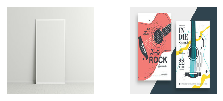

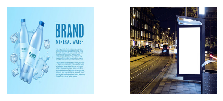

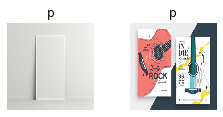

In [143]:

#q_, p_, n_, q_batch, p_batch, n_batch, encoded_anchor = query_visualization_batches(query)
psq_dist, nsq_dist = precision_ranking_score_euc_distance(encoded_anchor, p_batch, n_batch)
ranking_list, precision = compute_precision_dist(2, psq_dist,nsq_dist)
visualize_images(p_,2)
visualize_images(n_,2)



ranked_img_path = [ranking_list[i][2] for i in range(len(ranking_list))]
ranking_labels = [ranking_list[i][0] for i in range(len(ranking_list))]

visualize_images(ranked_img_path,2, ranking_labels)




In [96]:
ranking_list, precision = compute_precision_dist(5, psq_dist,nsq_dist)
ranking_list, precision = compute_precision_dist(10, psq_dist,nsq_dist)
ranking_list, precision = compute_precision_dist(15, psq_dist,nsq_dist)
ranking_list, precision = compute_precision_dist(20, psq_dist,nsq_dist)
ranking_list, precision = compute_precision_dist(25, psq_dist,nsq_dist)


@5 precision for query social media based on Euclidean Distance of images :  0.6
@10 precision for query social media based on Euclidean Distance of images :  0.8
@15 precision for query social media based on Euclidean Distance of images :  0.8
@20 precision for query social media based on Euclidean Distance of images :  0.85
@25 precision for query social media based on Euclidean Distance of images :  0.88


In [98]:
n_rank = 20 # number of quries to visualize

queries = freq_count.index[0:n_rank]
precisions = {'5': 0 , '10': 0 , '15':0, '20':0, '25':0}

for ind, query in enumerate(queries):
    print('\nquery = ', query)
    list_of_indices = np.flatnonzero(df['query']== query)
    print("in test set with size {}, there are {} number of queries with text {}".format(len(df), len(list_of_indices), query ))

    q_ = list(itemgetter(* list_of_indices)(q_test)) #get query test associated with this query
    p_ = list(itemgetter(* list_of_indices)(p_test))
    n_ = list(itemgetter(* list_of_indices)(n_test))
    pb_ = list(itemgetter(* list_of_indices)(pb_test))
    query_size = len(list_of_indices)

    vis_batch = 1
    sample_pos_img_dataset = tf.data.Dataset.from_tensor_slices(p_)
    sample_pos_img_dataset = sample_pos_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

    sample_neg_img_dataset = tf.data.Dataset.from_tensor_slices(n_)
    sample_neg_img_dataset = sample_neg_img_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(vis_batch)

    sample_position_bias_dataset = tf.data.Dataset.from_generator(lambda: gen_series(pb_), output_types=(tf.float32),output_shapes = ( ())) # if set it (1,) -> ValueError: `generator` yielded an element of shape () where an element of shape (1,) was expected
    sample_position_bias_dataset = sample_position_bias_dataset.batch(vis_batch)

    sample_query_dataset = tf.data.Dataset.from_generator(
        lambda: gen_series(q_), 
        output_types=(tf.int32), 
        output_shapes=( ( MAX_SENT_LENGTH)))
    sample_query_dataset = sample_query_dataset.batch(vis_batch)

    sample_query_dataset, sample_neg_img_dataset, sample_pos_img_dataset

    p_batch = []   # I think the model is overfitted, as it return very similar encoding
    for batch , img in enumerate(sample_pos_img_dataset):
        p_batch.append(image_model(img))

    n_batch = []
    for batch , img in enumerate(sample_neg_img_dataset):
        n_batch.append(image_model(img))

    q_batch = [] 
    for batch , q in enumerate(sample_query_dataset):
        q_batch.append(text_model(q))

    anchor_query_seq = list(itemgetter(* list_of_indices)(q_test))[0]
    encoded_anchor = text_model(q)

    for ranks in [5,10,15,20,25]: # get precisions for @5, @10, @15 , ... 
        print('\nPrecisions @', ranks)

        #q_, p_, n_, q_batch, p_batch, n_batch, encoded_anchor = query_visualization_batches(query)
        psq_dist, nsq_dist = precision_ranking_score_euc_distance(encoded_anchor, p_batch, n_batch)
        ranking_list, precision = compute_precision_dist(ranks, psq_dist,nsq_dist)
        precisions[str(ranks)] += precision
        #ranked_img_path = [ranking_list[i][2] for i in range(len(ranking_list))]
        #ranking_labels = [ranking_list[i][0] for i in range(len(ranking_list))]
        #visualize_images(ranked_img_path,27, ranking_labels)
        
    precisions[str(ranks)] = precisions[str(ranks)]/len(queries)

{'5': 0, '10': 0, '15': 0, '20': 0, '25': 0, '30': 0}

## DOT Ranking

In [266]:
# precision (based on dot product: Ai > Ai+1) # anchor dot product to images are sorted descendingly
def precision_ranking_score(encoded_anchor, p_batch, n_batch):
    pos_dot = []
    neg_dot = []
    for batch , encoded_positive in enumerate(p_batch):
        pos_dot.append(float(tf.tensordot(encoded_anchor, tf.transpose(encoded_positive),1)[0]))
        
    for batch , encoded_negative in enumerate(n_batch):  
        neg_dot.append(float(tf.tensordot(encoded_anchor, tf.transpose(encoded_negative),1)[0]))
    return pos_dot,neg_dot

def compute_precision_dot(p_rank, pos_dot,neg_dot) :
    sorted_pos_ind = np.argsort(pos_dot)[::-1][:len(pos_dot)] #sort descending for dot product
    sorted_neg_ind = np.argsort(neg_dot)[::-1][:len(neg_dot)] 

    j = k = 0
    precision = 0
    ranking_list = []
    for i in range(p_rank):
        if pos_dot[sorted_pos_ind[j]] > neg_dot[sorted_neg_ind[k]]:
            print('p', 'index: {} dot value {}'.format(j, pos_dot[sorted_pos_ind[j]]))
            ranking_list.append(('p' ,j, p_[j]))
            precision+=1
            j+=1
        else:
            print('n', 'index: {} dot value {}'.format (k, neg_dot[sorted_neg_ind[k]]))
            ranking_list.append(('n' ,k, n_[k]))
            k+=1
    print('@{} precision for query {} based on dot product of images : '.format(p_rank , query), precision/p_rank)
    return ranking_list, precision

pos_dot,neg_dot = precision_ranking_score( encoded_anchor, p_batch, n_batch)
ranking_list, precision = compute_precision_dot(49, pos_dot,neg_dot)

### VISUALIZE rankings based on dot product
ranked_img_path = [ranking_list[i][2] for i in range(len(ranking_list))]

visualize_images(ranked_img_path,49)



## Ranking based on Euclidean distance

In [242]:
# precision (based on dot product: Ai > Ai+1) # anchor dot product to images are sorted ascendingly
def precision_ranking_score_euc_distance(query, query_seqs, p_img_paths,n_img_paths, position_bias, n_train):
    
    # calculate euclidean distance ( or cosine similarity score) here dot product first
    anchor_vector = p_batch[0][0].numpy()
    # normalize vector
    encoded_anchor = tf.math.l2_normalize(anchor_vector, axis=None, epsilon=1e-12, name=None)
    
    ## calculate dot (or distance) between the query and pos and neg image encodings (within test set and )
    psq_dist = []
    nsq_dist = []

    for batch , sample in enumerate(p_batch):
        #sample = tf.math.l2_normalize(sample, axis=None, epsilon=1e-12, name=None)
        pos_dot = float(tf.tensordot(encoded_anchor, tf.transpose(sample),1)[0])
        psq_dist.append(np.absolute(float(tf.math.square(tf.norm(encoded_anchor)) + tf.math.square(tf.norm(sample)) - 2*pos_dot)))
    
    for batch , sample in enumerate(n_batch):  
        #sample = tf.math.l2_normalize(sample, axis=None, epsilon=1e-12, name=None)
        neg_dot = float(tf.tensordot(encoded_anchor, tf.transpose(sample),1)[0])
        nsq_dist.append(np.absolute(float(tf.math.square(tf.norm(encoded_anchor)) + tf.math.square(tf.norm(sample)) - 2*neg_dot)))
    
    return psq_dist,nsq_dist, p_, n_


In [260]:
def compute_precision_dist(p_rank, psq_dist,nsq_dist) :
    sorted_pos_ind = np.argsort(psq_dist)#[::-1][:len(pos_dot)] #sort ascending for euc dis
    print(sorted_pos_ind)
    sorted_neg_ind = np.argsort(nsq_dist)#[::-1][:len(neg_dot)] 
    print(sorted_neg_ind)
    
    j = k = 0
    precision = 0
    ranking_list = []
    for i in range(p_rank):
        
        if psq_dist[sorted_pos_ind[j]] < nsq_dist[sorted_neg_ind[k]]: # lower distance means better
            print('p', 'index: {} dot value {}'.format(j, psq_dist[sorted_pos_ind[j]]))
            ranking_list.append(('p' ,j, p_[j]))
            precision+=1
            j+=1
        else:
            print('n', 'index: {} dot value {}'.format (k, nsq_dist[sorted_neg_ind[k]]))
            ranking_list.append(('n' ,k, n_[k]))
            k+=1
    print('@{} precision for query {} based on Euclidean Distance of images : '.format(p_rank , query), precision/p_rank)
    return ranking_list, precision


In [53]:
query = 'happy holidays'
psq_dist, nsq_dist, p_, n_ = precision_ranking_score_euc_distance(query, query_seqs, p_img_paths,n_img_paths, position_bias, n_train)
ranking_list, precision = compute_precision_dist(19, psq_dist,nsq_dist)
print( precision)
ranked_img_path = [ranking_list[i][2] for i in range(len(ranking_list))]
visualize_image_ranks(ranked_img_path)

NameError: name 'precision_ranking_score_euc_distance' is not defined